<h1>Buffer Analysis and Optimization</h1>

In [1]:
from properties import nr_runs, l_min_pmos, w_min_pmos, l_min_nmos, w_min_nmos, S1, S2, S_LOAD, tran, rit_models, save_s1, save_s2
from utils.conversion import to_order, Order
from utils.paths import ltspice, images, buffer_data, minimum_inverter_data, matlab
from utils.patterns import s1_pattern, s2_pattern, energy_connected_pattern, energy_disconnected_pattern, rise_delay_connected_pattern, fall_delay_connected_pattern, rise_delay_disconnected_pattern, fall_delay_disconnected_pattern
from utils.check import check_output_image
from optimization.optimize_function import optimize_considering_delay
from PyLTSpice import SimRunner
import re
import statistics as st
import matplotlib.pyplot as plt
import os
from models.ops import load, energy_connected, energy_disconnected, rise_delay_connected, rise_delay_disconnected, fall_delay_connected, fall_delay_disconnected

<h2>Buffer Analysis</h2>

File opened successfully: ../../ltspice/models/buffer/standard/buffer.raw
File opened successfully: ../../ltspice/models/buffer/standard/buffer.asc


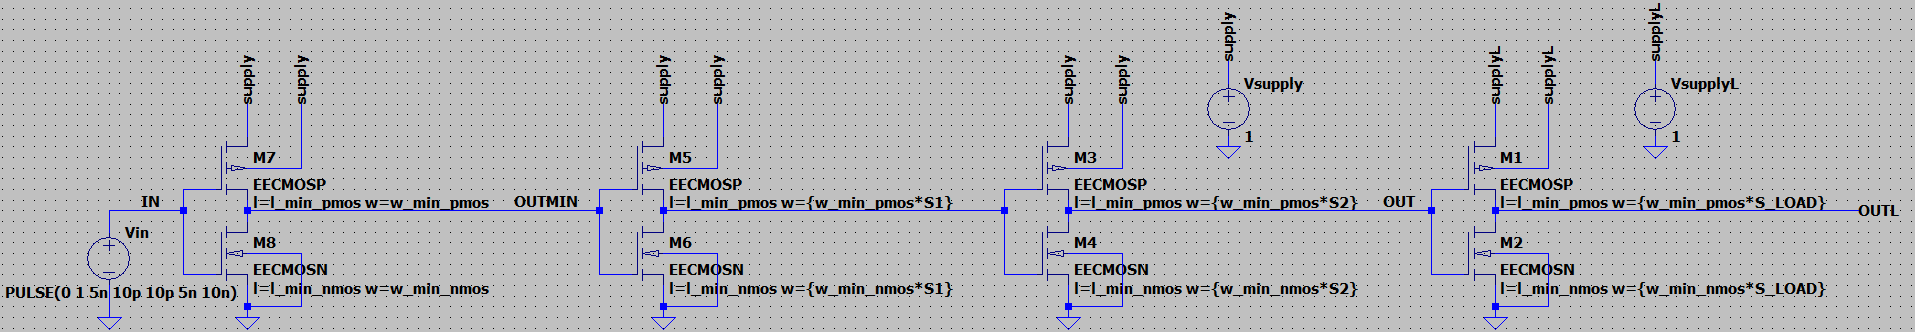

Thu Nov  9 20:23:32 2023 info: RunTask #1:: Starting simulation 1

Successful/Total Simulations: 0/1
Thu Nov  9 20:23:58 2023 info: RunTask #1:Simulation Successful. Time elapsed: 25.0374 secs

Thu Nov  9 20:23:58 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\buffer\standard\buffer_1.raw, Log file: data\buffer\standard\buffer_1.log
File updated successfully: ../../images/buffer_simulation.png


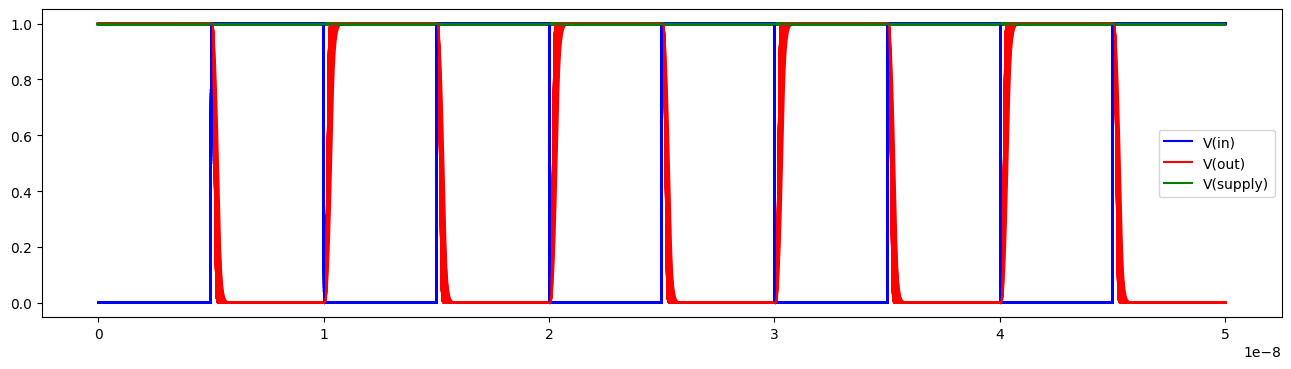

In [2]:
buffer_ltr, buffer_netlist = load(
                                    raw_file_path=os.path.join(ltspice, "buffer/standard/buffer.raw"), 
                                    asc_file_path=os.path.join(ltspice, "buffer/standard/buffer.asc"), 
                                    schematic_image_path=os.path.join(images, "buffer.png")
                                )
buffer_netlist.set_parameter('l_min_pmos', l_min_pmos)
buffer_netlist.set_parameter('w_min_pmos', w_min_pmos)
buffer_netlist.set_parameter('l_min_nmos', l_min_nmos)
buffer_netlist.set_parameter('w_min_nmos', w_min_nmos)
buffer_netlist.set_parameter('S1', S1)
buffer_netlist.set_parameter('S2', S2)
buffer_netlist.set_parameter('S_LOAD', S_LOAD)
buffer_netlist.add_instructions(
                                rit_models,
                                tran,
                                f".step param run 1 {nr_runs} 1",
                                save_s1,
                                save_s2,
                                energy_connected(13, 22),
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
buffer_runner = SimRunner(output_folder=f"{buffer_data}/standard/")
buffer_runner.run(netlist=buffer_netlist, timeout=3600)
print('Successful/Total Simulations: ' + str(buffer_runner.okSim) + '/' + str(buffer_runner.runno))

buffer_log = ""
for buffer_raw, buffer_log in buffer_runner:
    print("Raw file: %s, Log file: %s" % (buffer_raw, buffer_log))
    

v_in_buffer = buffer_ltr.get_trace("V(in)")
v_out_buffer = buffer_ltr.get_trace("V(out)")
v_supply_buffer = buffer_ltr.get_trace("V(supply)")
time = buffer_ltr.get_trace('time')
steps = buffer_ltr.get_steps()

plt.figure(figsize=(16, 4))
for step in range(len(steps)):
    plt.plot(time.get_wave(step), v_in_buffer.get_wave(step), label=steps[step], color='blue')
    plt.plot(time.get_wave(step), v_out_buffer.get_wave(step), label=steps[step], color='red')
    plt.plot(time.get_wave(step), v_supply_buffer.get_wave(step), label=steps[step], color='green')
plt.legend(["V(in)", "V(out)", "V(supply)"])
buffer_simulation_path_image = os.path.join(images, "buffer_simulation.png")
check_output_image(buffer_simulation_path_image)
plt.savefig(buffer_simulation_path_image)
plt.show()

File updated successfully: ../../images/s1_s2_montecarlo_trend.png


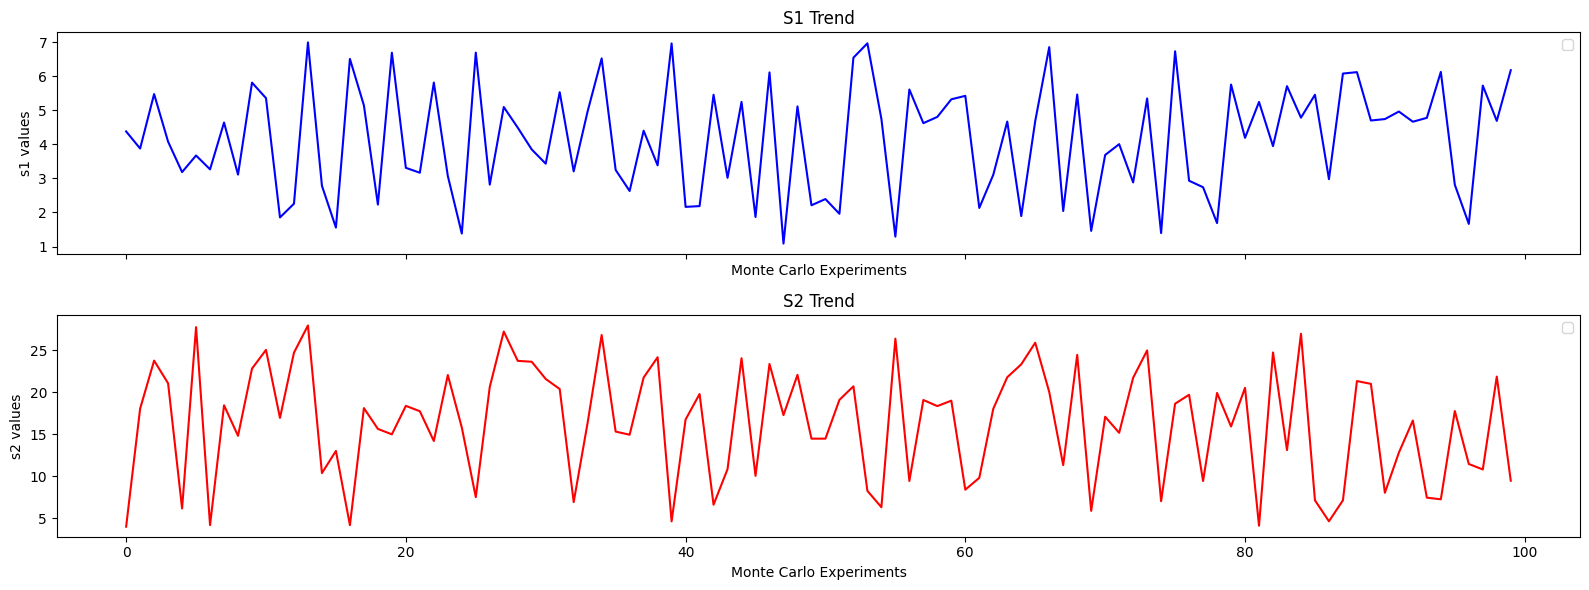

In [3]:
buffer_log_file_path = f"./{buffer_log}"

with open(buffer_log_file_path, "r") as file:
    content = file.read()

s1_data = re.search(s1_pattern, content, re.DOTALL).group(1)
s2_data = re.search(s2_pattern, content, re.DOTALL).group(1)
energy_connected_buffer_data = re.search(energy_connected_pattern, content, re.DOTALL).group(1)
rise_delay_connected_buffer_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_connected_buffer_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

s1_lines = s1_data.strip().split('\n')[1:]
s2_lines = s2_data.strip().split('\n')[1:]
energy_connected_buffer_lines = energy_connected_buffer_data.strip().split('\n')[1:]
rise_delay_connected_buffer_lines = rise_delay_connected_buffer_data.strip().split('\n')[1:]
fall_delay_connected_buffer_lines = fall_delay_connected_buffer_data.strip().split('\n')[1:]


s1 = [float(line.split('\t')[1]) for line in s1_lines]
s2 = [float(line.split('\t')[1]) for line in s2_lines]


energy_connected_buffer = [float(line.split('\t')[1]) for line in energy_connected_buffer_lines]

energy_connected_buffer = [abs(energy) for energy in energy_connected_buffer]

rise_delay_connected_buffer = [float(line.split('\t')[1]) for line in rise_delay_connected_buffer_lines]

fall_delay_connected_buffer = [float(line.split('\t')[1]) for line in fall_delay_connected_buffer_lines]

delay_connected_buffer = [(rise_delay+fall_delay)/2 for rise_delay,fall_delay in zip(rise_delay_connected_buffer,fall_delay_connected_buffer)]

    
fig, (plt1, plt2) = plt.subplots(2, 1, sharex=True, figsize=(16, 6))
plt1.legend(['S1']); plt2.legend(['S2'])
plt1.plot(s1, label='s1', color='b')
plt1.set_ylabel('s1 values'); plt1.set_xlabel('Monte Carlo Experiments'); plt1.set_title('S1 Trend')
plt2.plot(s2, label='s2', color='r')
plt2.set_xlabel('Monte Carlo Experiments'); plt2.set_ylabel('s2 values'); plt2.set_title('S2 Trend')
plt.tight_layout()
s1_s2_montecarlo_trend_path_image = os.path.join(images, "s1_s2_montecarlo_trend.png")
check_output_image(s1_s2_montecarlo_trend_path_image)
plt.savefig(s1_s2_montecarlo_trend_path_image)
plt.show()

<h2>Minimum Inverter Connected Analysis</h2>

File opened successfully: ../../ltspice/models/minimum-inverter/connected/minimum_inverter_connected.raw
File opened successfully: ../../ltspice/models/minimum-inverter/connected/minimum_inverter_connected.asc


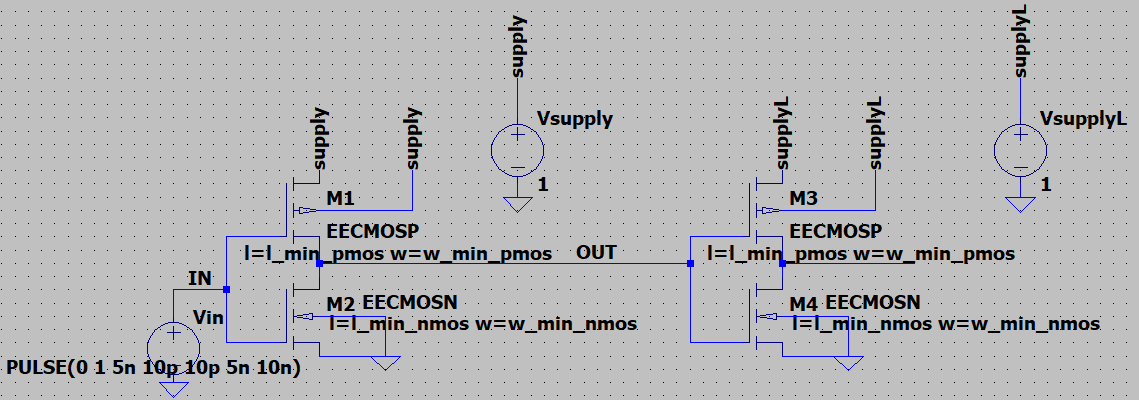

Thu Nov  9 20:24:02 2023 info: RunTask #1:: Starting simulation 1
Thu Nov  9 20:24:04 2023 info: RunTask #1:Simulation Successful. Time elapsed: 01.0926 secs

Thu Nov  9 20:24:04 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\minimum-inverter\connected\minimum_inverter_connected_1.raw, Log file: data\minimum-inverter\connected\minimum_inverter_connected_1.log


In [4]:
minimum_inverter_connected_ltr, minimum_inverter_connected_netlist = load(
                                    raw_file_path=os.path.join(ltspice, "minimum-inverter/connected/minimum_inverter_connected.raw"), 
                                    asc_file_path=os.path.join(ltspice, "minimum-inverter/connected/minimum_inverter_connected.asc"), 
                                    schematic_image_path=os.path.join(images, "minimum_inverter_connected.png")
                                )
minimum_inverter_connected_netlist.set_parameter('l_min_pmos', l_min_pmos)
minimum_inverter_connected_netlist.set_parameter('w_min_pmos', w_min_pmos)
minimum_inverter_connected_netlist.set_parameter('l_min_nmos', l_min_nmos)
minimum_inverter_connected_netlist.set_parameter('w_min_nmos', w_min_nmos)
minimum_inverter_connected_netlist.add_instructions(
                                rit_models,
                                tran,
                                ".step param run 1 2 1",
                                energy_connected(18, 22),
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
minimum_inverter_connected_runner = SimRunner(output_folder=f"{minimum_inverter_data}/connected/")
minimum_inverter_connected_runner.run(minimum_inverter_connected_netlist)

minimum_inverter_connected_log = ""
for minimum_inverter_connected_raw, minimum_inverter_connected_log in minimum_inverter_connected_runner:
    print("Raw file: %s, Log file: %s" % (minimum_inverter_connected_raw, minimum_inverter_connected_log))

In [5]:
minimum_inverter_connected_log_file_path = f"./{minimum_inverter_connected_log}"

with open(minimum_inverter_connected_log_file_path, "r") as file:
    content = file.read()

energy_connected_minimum_inverter_data = re.search(energy_connected_pattern, content, re.DOTALL).group(1)
rise_delay_connected_minimum_inverter_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_connected_minimum_inverter_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

energy_connected_minimum_inverter_lines = energy_connected_minimum_inverter_data.strip().split('\n')[1:]
rise_delay_connected_minimum_inverter_lines = rise_delay_connected_minimum_inverter_data.strip().split('\n')[1:]
fall_delay_connected_minimum_inverter_lines = fall_delay_connected_minimum_inverter_data.strip().split('\n')[1:]


energy_connected_minimum_inverter = [float(line.split('\t')[1]) for line in energy_connected_minimum_inverter_lines]

energy_connected_minimum_inverter = [abs(energy) for energy in energy_connected_minimum_inverter]

rise_delay_connected_minimum_inverter = [float(line.split('\t')[1]) for line in rise_delay_connected_minimum_inverter_lines]

fall_delay_connected_minimum_inverter = [float(line.split('\t')[1]) for line in fall_delay_connected_minimum_inverter_lines]

<h2>Minimum Inverter Disconnected Analysis</h2>

File opened successfully: ../../ltspice/models/minimum-inverter/disconnected/minimum_inverter_disconnected.raw
File opened successfully: ../../ltspice/models/minimum-inverter/disconnected/minimum_inverter_disconnected.asc


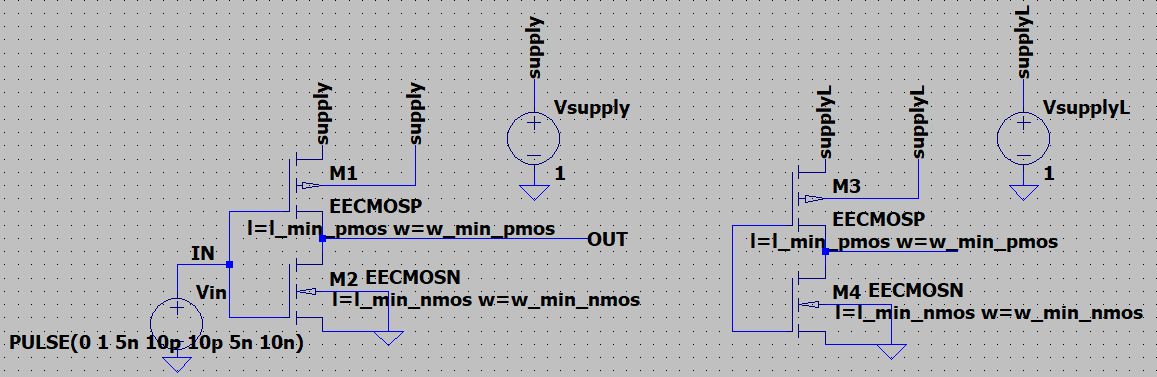

Thu Nov  9 20:24:05 2023 info: RunTask #1:: Starting simulation 1
Thu Nov  9 20:24:07 2023 info: RunTask #1:Simulation Successful. Time elapsed: 01.0689 secs

Thu Nov  9 20:24:07 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\minimum-inverter\disconnected\minimum_inverter_disconnected_1.raw, Log file: data\minimum-inverter\disconnected\minimum_inverter_disconnected_1.log


In [6]:
minimum_inverter_disconnected_ltr, minimum_inverter_disconnected_netlist = load(
                                    raw_file_path=os.path.join(ltspice, "minimum-inverter/disconnected/minimum_inverter_disconnected.raw"), 
                                    asc_file_path=os.path.join(ltspice, "minimum-inverter/disconnected/minimum_inverter_disconnected.asc"), 
                                    schematic_image_path=os.path.join(images, "minimum_inverter_disconnected.png")
                                )
minimum_inverter_disconnected_netlist.set_parameter('l_min_pmos', l_min_pmos)
minimum_inverter_disconnected_netlist.set_parameter('w_min_pmos', w_min_pmos)
minimum_inverter_disconnected_netlist.set_parameter('l_min_nmos', l_min_nmos)
minimum_inverter_disconnected_netlist.set_parameter('w_min_nmos', w_min_nmos)
minimum_inverter_disconnected_netlist.add_instructions(
                                rit_models,
                                tran,
                                ".step param run 1 2 1",
                                energy_disconnected(18, 22),
                                rise_delay_disconnected(),
                                fall_delay_disconnected()
                        )
minimum_inverter_disconnected_runner = SimRunner(output_folder=f"{minimum_inverter_data}/disconnected/")
minimum_inverter_disconnected_runner.run(minimum_inverter_disconnected_netlist)

minimum_inverter_disconnected_log = ""
for minimum_inverter_disconnected_raw, minimum_inverter_disconnected_log in minimum_inverter_disconnected_runner:
    print("Raw file: %s, Log file: %s" % (minimum_inverter_disconnected_raw, minimum_inverter_disconnected_log))

In [7]:
minimum_inverter_disconnected_log_file_path = f"./{minimum_inverter_disconnected_log}"

with open(minimum_inverter_disconnected_log_file_path, "r") as file:
    content = file.read()

energy_disconnected_minimum_inverter_data = re.search(energy_disconnected_pattern, content, re.DOTALL).group(1)
rise_delay_disconnected_minimum_inverter_data = re.search(rise_delay_disconnected_pattern, content, re.DOTALL).group(1)
fall_delay_disconnected_minimum_inverter_data = re.search(fall_delay_disconnected_pattern, content, re.DOTALL).group(1)

energy_disconnected_minimum_inverter_lines = energy_disconnected_minimum_inverter_data.strip().split('\n')[1:]
rise_delay_disconnected_minimum_inverter_lines = rise_delay_disconnected_minimum_inverter_data.strip().split('\n')[1:]
fall_delay_disconnected_minimum_inverter_lines = fall_delay_disconnected_minimum_inverter_data.strip().split('\n')[1:]


energy_disconnected_minimum_inverter = [float(line.split('\t')[1]) for line in energy_disconnected_minimum_inverter_lines]

energy_disconnected_minimum_inverter = [abs(energy) for energy in energy_disconnected_minimum_inverter]

rise_delay_disconnected_minimum_inverter = [float(line.split('\t')[1]) for line in rise_delay_disconnected_minimum_inverter_lines]

fall_delay_disconnected_minimum_inverter = [float(line.split('\t')[1]) for line in fall_delay_disconnected_minimum_inverter_lines]

delay_disconnected_minimum_inverter = [(rise_delay+fall_delay)/2 for rise_delay,fall_delay in zip(rise_delay_disconnected_minimum_inverter,fall_delay_disconnected_minimum_inverter)]

<h2>Overall Buffer Analysis via Monte Carlo Experiments</h2>

File updated successfully: ../../images/montecarlo_experiments.png


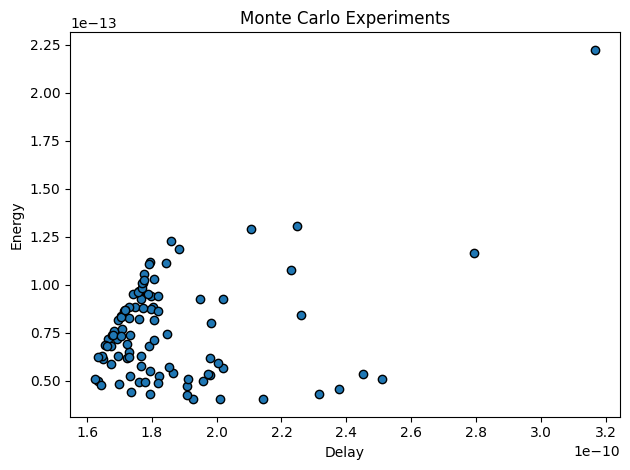

In [8]:
plt.scatter(delay_connected_buffer, energy_connected_buffer, edgecolors='black')
plt.xlabel('Delay'); plt.ylabel('Energy'); plt.title('Monte Carlo Experiments')
plt.tight_layout()
scatter_montecarlo_experiments_path_image = os.path.join(images, "montecarlo_experiments.png")
check_output_image(scatter_montecarlo_experiments_path_image)
plt.savefig(scatter_montecarlo_experiments_path_image)
plt.show()

In [9]:
vdd = 1

c_tot = [energy / (vdd*vdd) for energy in energy_connected_minimum_inverter]

c_out = [energy / (vdd*vdd) for energy in energy_disconnected_minimum_inverter]

c_in = [c_tot - c_out for c_tot, c_out in zip(c_tot, c_out)]

c_min = c_in[0]

print(f"c_min = {c_min}")
c_min_for_optimization = to_order(c_min, Order.FEMTO)
print(f"c_min_for_optimization = {c_min_for_optimization}")

gamma_e = [c_out / c_in for c_out, c_in in zip(c_out, c_in)]
print(f"gamma_e_max = {max(gamma_e)}")
print(f"gamma_e_min = {min(gamma_e)}")
gamma_e = st.mean(gamma_e)
print(f"gamma_e = {gamma_e}")

c_min = 7.898e-16
c_min_for_optimization = 0.7898
gamma_e_max = 0.6597872879209926
gamma_e_min = 0.6597872879209926
gamma_e = 0.6597872879209926


In [10]:
tau_nom = delay_disconnected_minimum_inverter
tau_nom = st.mean(tau_nom)
print(f"tau_nom = {tau_nom}")
tau_nom_for_optimization = to_order(tau_nom, Order.PICO)
print(f"tau_nom_for_optimization = {tau_nom_for_optimization}")

tau_tot = delay_connected_buffer

s_load = 50

temp1 = [tau_nom / (tau_tot-(3*tau_nom)) for tau_tot in tau_tot]
temp2 = [s1 + (s2/s1) + (s_load/s2) for s1, s2 in zip(s1, s2)]
gamma_d =  [tmp1 * tmp2 for tmp1, tmp2 in zip(temp1, temp2)]
print(f"gamma_d_max = {max(gamma_d)}")
print(f"gamma_d_min = {min(gamma_d)}")
gamma_d = st.mean( gamma_d )
print(f"gamma_d = {gamma_d}")

tau_nom = 7.919065e-12
tau_nom_for_optimization = 7.919065
gamma_d_max = 0.6826585535878392
gamma_d_min = 0.6143764814109257
gamma_d = 0.6340631019546391


<h1>Optmization</h1>

File updated successfully: ../../images/s1_s2_optimized.png


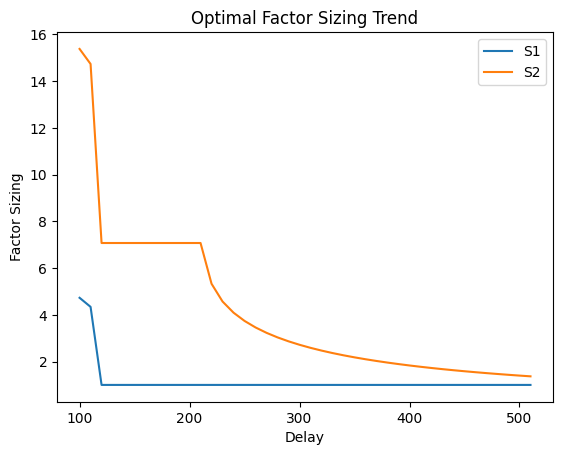

delay      optimal_point                  objective_f_value                   iterations     
510        [1.         1.36742624]        43.11455905394637                   11             
500        [1.         1.39928291]        43.15631996981877                   12             
490        [1.       1.432732]            43.200168382153414                  14             
480        [1.         1.46788878]        43.24625540392547                   11             
470        [1.         1.50489827]        43.29477114238626                   11             
460        [1.         1.54391129]        43.34591330583202                   10             
450        [1.         1.58512106]        43.39993520225526                   10             
440        [1.         1.62871864]        43.45708727121444                   11             
430        [1.         1.67492437]        43.51765835704468                   10             
420        [1.         1.72399056]        43.581979224392846

In [11]:
optimal_results = []

c_min = c_min_for_optimization
tau_nom = tau_nom_for_optimization
s0 = [10, 10]
max_iter = 10000

var1_values = []
var2_values = []
delay_values = []

d_max = 510
d_min = 100
step = 10

for delay in range(d_max, d_min - 1, -step):
    variables, energy_value, iteration_count = optimize_considering_delay(delay, tau_nom, gamma_d, s_load, vdd, c_min, gamma_e, s0, max_iter)
    optimal_results.append((delay, variables, energy_value, iteration_count))
    var1_values.append(variables[0])
    var2_values.append(variables[1])
    delay_values.append(delay)

plt.plot(delay_values, var1_values, label='S1')
plt.plot(delay_values, var2_values, label='S2')
plt.legend()
plt.xlabel('Delay'); plt.ylabel('Factor Sizing'); plt.title('Optimal Factor Sizing Trend')
s1_s2_optimized_path_image = os.path.join(images, "s1_s2_optimized.png")
check_output_image(s1_s2_optimized_path_image)
plt.savefig(s1_s2_optimized_path_image)
plt.show()

print("{:<10} {:<30} {:<35} {:<15}".format("delay", "optimal_point", "objective_f_value", "iterations"))
for delay, variables, energy_value, iteration_count in optimal_results:
    print("{:<10} {:<30} {:<35} {:<15}".format(delay, str(variables), energy_value, iteration_count))

<h2>Comparative Analysis</h2>

File opened successfully: ../../ltspice/models/buffer/optimized/buffer_optimized.raw
File opened successfully: ../../ltspice/models/buffer/optimized/buffer_optimized.asc


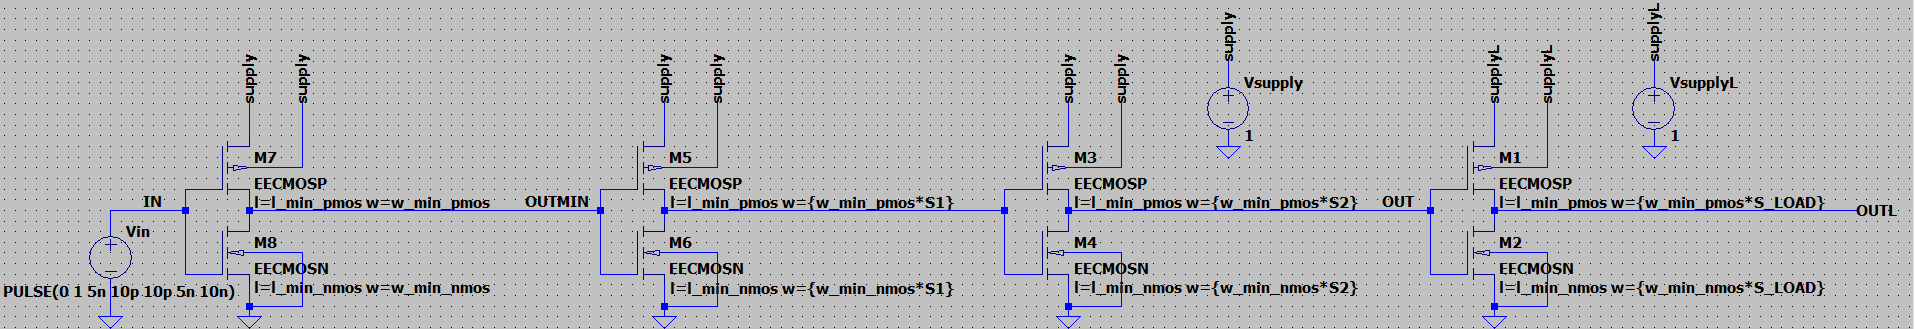

Thu Nov  9 20:24:15 2023 info: RunTask #1:: Starting simulation 1
Thu Nov  9 20:24:23 2023 info: RunTask #1:Simulation Successful. Time elapsed: 08.0051 secs

Thu Nov  9 20:24:23 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\buffer\optimized\buffer_optimized_1.raw, Log file: data\buffer\optimized\buffer_optimized_1.log
File updated successfully: ../../images/buffer_optimized_simulation.png


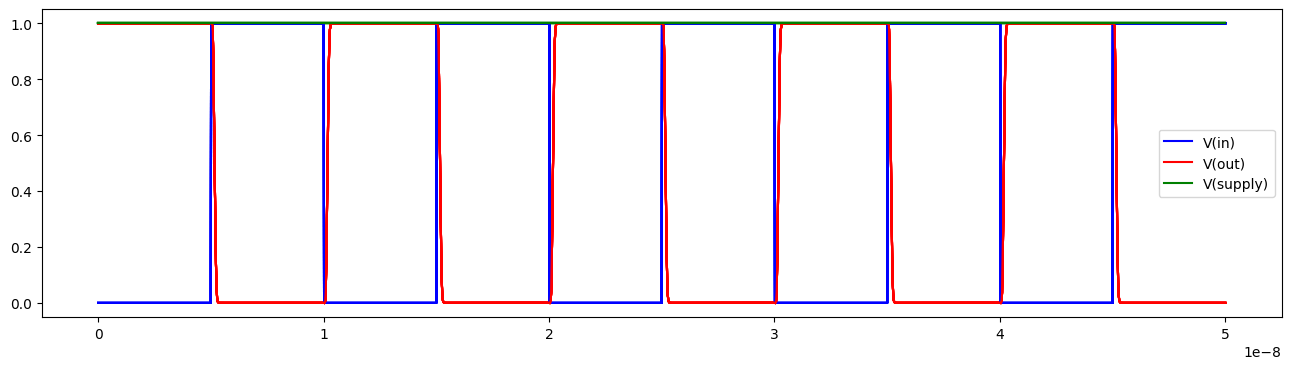

In [12]:
buffer_optimized_ltr, buffer_optimized_netlist = load(
                                    raw_file_path=os.path.join(ltspice, "buffer/optimized/buffer_optimized.raw"), 
                                    asc_file_path=os.path.join(ltspice, "buffer/optimized/buffer_optimized.asc"), 
                                    schematic_image_path=os.path.join(images, "buffer_optimized.png")
                                )
n_runs_optimized = ((d_max - d_min)/step) + 1

tmp_s1 = [(str(var1)+"," if var1!=var1_values[len(var1_values)-1] else str(var1)) for var1 in var1_values]
s1_table_optimized = ""
for item in tmp_s1:
    s1_table_optimized = s1_table_optimized + item
tmp_s2 = [(str(var2)+"," if var2!=var2_values[len(var2_values)-1] else str(var2)) for var2 in var2_values]
s2_table_optimized = ""
for item in tmp_s2:
    s2_table_optimized = s2_table_optimized + item

S1_optimized = f' table(index,{s1_table_optimized})'
S2_optimized = f' table(index,{s2_table_optimized})'

buffer_optimized_netlist.set_parameter('l_min_pmos', l_min_pmos)
buffer_optimized_netlist.set_parameter('w_min_pmos', w_min_pmos)
buffer_optimized_netlist.set_parameter('l_min_nmos', l_min_nmos)
buffer_optimized_netlist.set_parameter('w_min_nmos', w_min_nmos)
buffer_optimized_netlist.set_parameter('S1', S1_optimized)
buffer_optimized_netlist.set_parameter('S2', S2_optimized)
buffer_optimized_netlist.set_parameter('S_LOAD', S_LOAD)
buffer_optimized_netlist.add_instructions(
                                rit_models,
                                tran,
                                f".step param index 1 {n_runs_optimized} 1",
                                energy_connected(13,22),
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
buffer_optimized_runner = SimRunner(output_folder=f"{buffer_data}/optimized/")
buffer_optimized_runner.run(buffer_optimized_netlist)

buffer_optimized_log = ""
for buffer_optimized_raw, buffer_optimized_log in buffer_optimized_runner:
    print("Raw file: %s, Log file: %s" % (buffer_optimized_raw, buffer_optimized_log))


v_in_buffer_optimized = buffer_optimized_ltr.get_trace("V(in)")
v_out_buffer_optimized = buffer_optimized_ltr.get_trace("V(out)")
v_supply_buffer_optimized = buffer_optimized_ltr.get_trace("V(supply)")
time = buffer_optimized_ltr.get_trace('time')
steps = buffer_optimized_ltr.get_steps()

plt.figure(figsize=(16, 4))
for step in range(len(steps)):
    plt.plot(time.get_wave(step), v_in_buffer_optimized.get_wave(step), label=steps[step], color='blue')
    plt.plot(time.get_wave(step), v_out_buffer_optimized.get_wave(step), label=steps[step], color='red')
    plt.plot(time.get_wave(step), v_supply_buffer_optimized.get_wave(step), label=steps[step], color='green')
plt.legend(["V(in)", "V(out)", "V(supply)"])
buffer_optimized_simulation_path_image = os.path.join(images, "buffer_optimized_simulation.png")
check_output_image(buffer_optimized_simulation_path_image)
plt.savefig(buffer_optimized_simulation_path_image)
plt.show()

In [13]:
buffer_optimized_log_file_path = f"./{buffer_optimized_log}"

with open(buffer_optimized_log_file_path, "r") as file:
    content = file.read()

energy_connected_buffer_optimized_data = re.search(energy_connected_pattern, content, re.DOTALL).group(1)
rise_delay_connected_buffer_optimized_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_connected_buffer_optimized_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

energy_connected_buffer_optimized_lines = energy_connected_buffer_optimized_data.strip().split('\n')[1:]
rise_delay_connected_buffer_optimized_lines = rise_delay_connected_buffer_optimized_data.strip().split('\n')[1:]
fall_delay_connected_buffer_optimized_lines = fall_delay_connected_buffer_optimized_data.strip().split('\n')[1:]


energy_connected_buffer_optimized = [float(line.split('\t')[1]) for line in energy_connected_buffer_optimized_lines]
energy_connected_buffer_optimized = [abs(energy) for energy in energy_connected_buffer_optimized]

rise_delay_connected_buffer_optimized = [float(line.split('\t')[1]) for line in rise_delay_connected_buffer_optimized_lines]

fall_delay_connected_buffer_optimized = [float(line.split('\t')[1]) for line in fall_delay_connected_buffer_optimized_lines]

delay_connected_buffer_optimized = [(rise_delay+fall_delay)/2 for rise_delay,fall_delay in zip(rise_delay_connected_buffer_optimized,fall_delay_connected_buffer_optimized)]

File updated successfully: ../../images/comparative_analysis.png


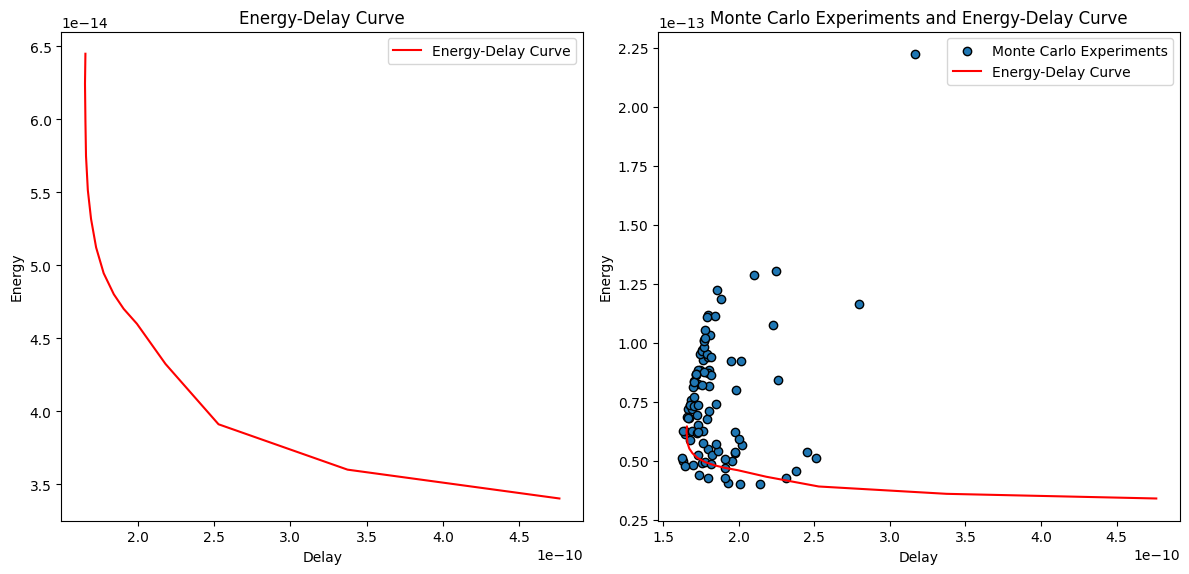

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(delay_connected_buffer_optimized, energy_connected_buffer_optimized, color='red')
axs[0].set_xlabel('Delay')
axs[0].set_ylabel('Energy')
axs[0].set_title('Energy-Delay Curve')
axs[0].legend(["Energy-Delay Curve"])

axs[1].scatter(delay_connected_buffer, energy_connected_buffer, edgecolors='black')
axs[1].plot(delay_connected_buffer_optimized, energy_connected_buffer_optimized, color='red')
axs[1].set_xlabel('Delay')
axs[1].set_ylabel('Energy')
axs[1].set_title('Monte Carlo Experiments and Energy-Delay Curve')
axs[1].legend(["Monte Carlo Experiments", "Energy-Delay Curve"])

plt.tight_layout()

comparative_analysis_path_image = os.path.join(images, "comparative_analysis.png")
check_output_image(comparative_analysis_path_image)
plt.savefig(comparative_analysis_path_image)
plt.show()

<h1>To MATLAB</h1>

In [15]:
data_to_matlab_file_path = os.path.join(matlab, "buffer_data.txt")

with open(data_to_matlab_file_path, "w") as file:
    file.truncate(0)
    file.write(f"{vdd}\n")
    file.write(f"{c_min}\n")
    file.write(f"{gamma_e}\n")
    file.write(f"{tau_nom}\n")
    file.write(f"{gamma_d}\n")
    file.write(f"{S_LOAD}\n")
    file.write(f"{s0[0]}\n")
    file.write(f"{s0[1]}\n")
    file.write(f"{d_max}\n")
    file.write(f"{d_min}\n")

print(f"Variables written successfully: {data_to_matlab_file_path}")

Variables written successfully: ../../matlab/buffer_data.txt


<h1>From MATLAB</h1>
<strong>At this point you need to open MATLAB and run the '../../matlab/optimization' script so as to generate the optimized values of the sizing factors S1 and S2 and make a comparison between those generated by the 'fmincon' optimization algorithm present in MATLAB and those generated by the algorithm scipy.minimize optimization tool of type 'SLSQP'. Therefore, you will be asked if you can continue with the execution. This will only be possible by entering the word 'continue' in the popup window which will indicate that the MATLAB script has been executed and you can continue with the execution of the Jupyter notebook. Obviously this popup window is indicative. So much so that in the case of invalid input, execution continues as the exception is caught and handled. It is just to remind the user that before executing the next code it is necessary to execute the MATLAB script '../../matlab/optimization' because otherwise there would be a risk of generating errors or inconsistent results.</strong>

In [16]:
try:
    user_input = input("Write 'continue' if and only if the MATLAB script has been launched: ")
    if user_input.lower() == 'continue':
        print("You entered 'continue'. The execution continues.")
    else:
        raise ValueError("Input other than 'continue'. Execution stopped.")
except ValueError as e:
    print("Error:", e)


You entered 'continue'. The execution continues.


In [17]:
data_from_matlab_directory = f"{matlab}/data"
s1_data_from_matlab_file = "s1_data.txt"
s2_data_from_matlab_file = "s2_data.txt"
s1_data_from_matlab_file_path = os.path.join(data_from_matlab_directory, s1_data_from_matlab_file)
s2_data_from_matlab_file_path = os.path.join(data_from_matlab_directory, s2_data_from_matlab_file)
with open(s1_data_from_matlab_file_path, 'r') as s1_file:
    s1_lines = s1_file.readlines()
with open(s2_data_from_matlab_file_path, 'r') as s2_file:
    s2_lines = s2_file.readlines()

s1_from_matlab = []
s2_from_matlab = []

for line in s1_lines:
    columns = line.split()
    if columns:
        s1_value = columns[0]
        s1_from_matlab.append(float(s1_value))
for line in s2_lines:
    columns = line.split()
    if columns:
        s2_value = columns[0]
        s2_from_matlab.append(float(s2_value))

File opened successfully: ../../ltspice/models/buffer/optimized/buffer_optimized.raw
File opened successfully: ../../ltspice/models/buffer/optimized/buffer_optimized.asc


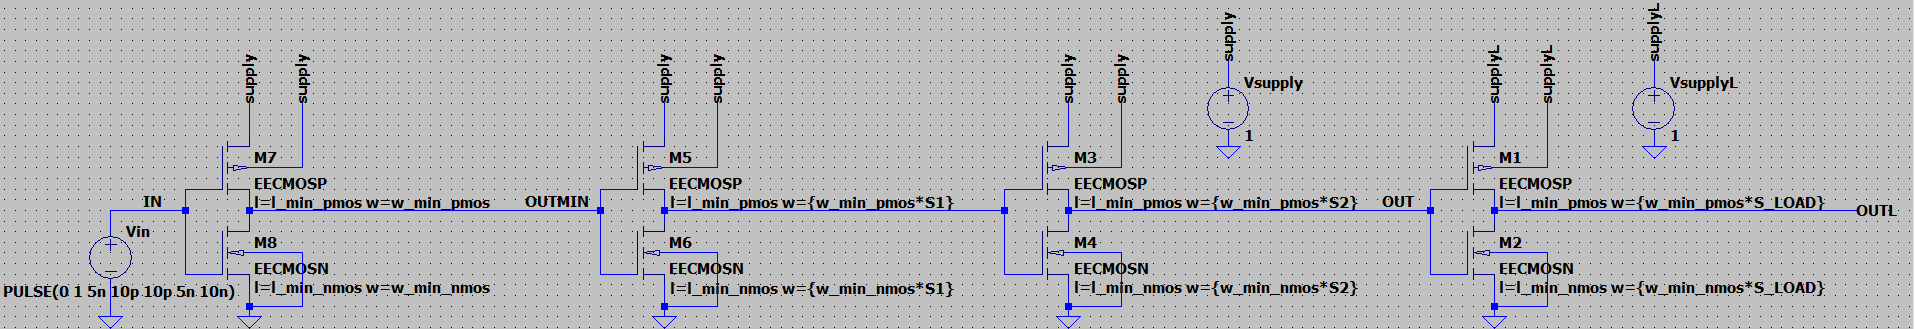

Thu Nov  9 20:24:39 2023 info: RunTask #1:: Starting simulation 1
Thu Nov  9 20:24:46 2023 info: RunTask #1:Simulation Successful. Time elapsed: 07.0631 secs

Thu Nov  9 20:24:46 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\buffer\optimized\buffer_optimized_1.raw, Log file: data\buffer\optimized\buffer_optimized_1.log
File updated successfully: ../../images/buffer_optimized_simulation.png


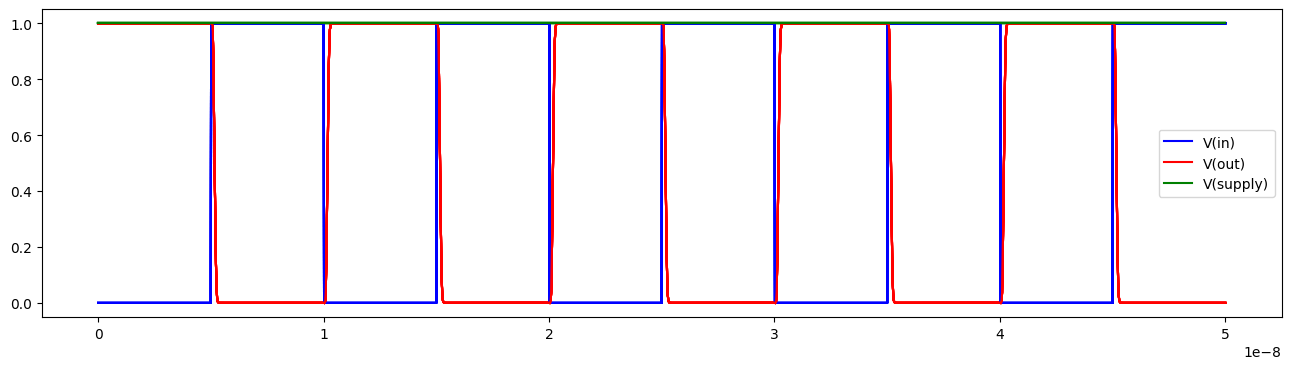

In [18]:
buffer_optimized_ltr, buffer_optimized_netlist = load(
                                    raw_file_path=os.path.join(ltspice, "buffer/optimized/buffer_optimized.raw"), 
                                    asc_file_path=os.path.join(ltspice, "buffer/optimized/buffer_optimized.asc"), 
                                    schematic_image_path=os.path.join(images, "buffer_optimized.png")
                                )
n_runs_optimized = ((d_max - d_min)/step) + 1

tmp_s1_from_matlab = [(str(var1)+"," if var1!=s1_from_matlab[len(s1_from_matlab)-1] else str(var1)) for var1 in s1_from_matlab]
s1_table_optimized_from_matlab = ""
for item in tmp_s1_from_matlab:
    s1_table_optimized_from_matlab = s1_table_optimized_from_matlab + item
tmp_s2_from_matlab = [(str(var2)+"," if var2!=s2_from_matlab[len(s2_from_matlab)-1] else str(var2)) for var2 in s2_from_matlab]
s2_table_optimized_from_matlab = ""
for item in tmp_s2_from_matlab:
    s2_table_optimized_from_matlab = s2_table_optimized_from_matlab + item

S1_optimized = f' table(index,{s1_table_optimized_from_matlab})'
S2_optimized = f' table(index,{s2_table_optimized_from_matlab})'

buffer_optimized_netlist.set_parameter('l_min_pmos', l_min_pmos)
buffer_optimized_netlist.set_parameter('w_min_pmos', w_min_pmos)
buffer_optimized_netlist.set_parameter('l_min_nmos', l_min_nmos)
buffer_optimized_netlist.set_parameter('w_min_nmos', w_min_nmos)
buffer_optimized_netlist.set_parameter('S1', S1_optimized)
buffer_optimized_netlist.set_parameter('S2', S2_optimized)
buffer_optimized_netlist.set_parameter('S_LOAD', S_LOAD)
buffer_optimized_netlist.add_instructions(
                                rit_models,
                                tran,
                                f".step param index 1 {n_runs_optimized} 1",
                                energy_connected(13,22),
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
buffer_optimized_runner = SimRunner(output_folder=f"{buffer_data}/optimized/")
buffer_optimized_runner.run(buffer_optimized_netlist)

buffer_optimized_log = ""
for buffer_optimized_raw, buffer_optimized_log in buffer_optimized_runner:
    print("Raw file: %s, Log file: %s" % (buffer_optimized_raw, buffer_optimized_log))
    

v_in_buffer_optimized = buffer_optimized_ltr.get_trace("V(in)")
v_out_buffer_optimized = buffer_optimized_ltr.get_trace("V(out)")
v_supply_buffer_optimized = buffer_optimized_ltr.get_trace("V(supply)")
time = buffer_optimized_ltr.get_trace('time')
steps = buffer_optimized_ltr.get_steps()

plt.figure(figsize=(16, 4))
for step in range(len(steps)):
    plt.plot(time.get_wave(step), v_in_buffer_optimized.get_wave(step), label=steps[step], color='blue')
    plt.plot(time.get_wave(step), v_out_buffer_optimized.get_wave(step), label=steps[step], color='red')
    plt.plot(time.get_wave(step), v_supply_buffer_optimized.get_wave(step), label=steps[step], color='green')
plt.legend(["V(in)", "V(out)", "V(supply)"])
buffer_optimized_simulation_path_image = os.path.join(images, "buffer_optimized_simulation.png")
check_output_image(buffer_optimized_simulation_path_image)
plt.savefig(buffer_optimized_simulation_path_image)
plt.show()

In [19]:
buffer_optimized_log_file_path = f"./{buffer_optimized_log}"

with open(buffer_optimized_log_file_path, "r") as file:
    content = file.read()

energy_connected_buffer_optimized_data = re.search(energy_connected_pattern, content, re.DOTALL).group(1)
rise_delay_connected_buffer_optimized_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_connected_buffer_optimized_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

energy_connected_buffer_optimized_lines = energy_connected_buffer_optimized_data.strip().split('\n')[1:]
rise_delay_connected_buffer_optimized_lines = rise_delay_connected_buffer_optimized_data.strip().split('\n')[1:]
fall_delay_connected_buffer_optimized_lines = fall_delay_connected_buffer_optimized_data.strip().split('\n')[1:]

energy_connected_buffer_optimized = [float(line.split('\t')[1]) for line in energy_connected_buffer_optimized_lines]
energy_connected_buffer_optimized = [abs(energy) for energy in energy_connected_buffer_optimized]
rise_delay_connected_buffer_optimized = [float(line.split('\t')[1]) for line in rise_delay_connected_buffer_optimized_lines]
fall_delay_connected_buffer_optimized = [float(line.split('\t')[1]) for line in fall_delay_connected_buffer_optimized_lines]
delay_connected_buffer_optimized = [(rise_delay+fall_delay)/2 for rise_delay,fall_delay in zip(rise_delay_connected_buffer_optimized,fall_delay_connected_buffer_optimized)]

File updated successfully: ../../images/comparative_analysis_matlab.png


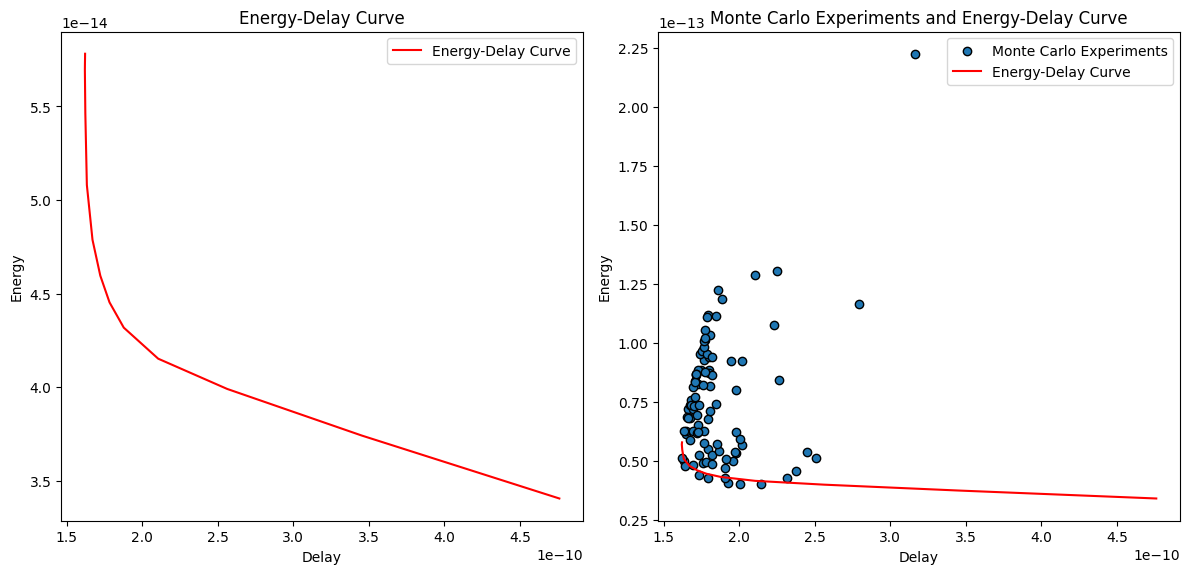

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(delay_connected_buffer_optimized, energy_connected_buffer_optimized, color='red')
axs[0].set_xlabel('Delay')
axs[0].set_ylabel('Energy')
axs[0].set_title('Energy-Delay Curve')
axs[0].legend(["Energy-Delay Curve"])

axs[1].scatter(delay_connected_buffer, energy_connected_buffer, edgecolors='black')
axs[1].plot(delay_connected_buffer_optimized, energy_connected_buffer_optimized, color='red')
axs[1].set_xlabel('Delay')
axs[1].set_ylabel('Energy')
axs[1].set_title('Monte Carlo Experiments and Energy-Delay Curve')
axs[1].legend(["Monte Carlo Experiments", "Energy-Delay Curve"])

plt.tight_layout()

comparative_analysis_path_image = os.path.join(images, "comparative_analysis_matlab.png")
check_output_image(comparative_analysis_path_image)
plt.savefig(comparative_analysis_path_image)
plt.show()